In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.over_sampling import ADASYN 
import sys
import sklearn.neighbors._base
sys.modules['sklearn.neighbors.base'] = sklearn.neighbors._base

In [2]:
# ! pip install missingpy
from missingpy import MissForest

In [ ]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [3]:
df = pd.read_csv('data/preprocessed-ukb46359.csv')
df

,Unnamed: 0,30850-0.0,30780-0.0,30690-0.0,1488-0.0,30790-0.0,1418-0.0,1329-0.0,4079-0.0,1220-0.0,...,1448-0.0,outcome_myocardial_infarction,outcome_cardiomyopathies,outcome_ischemic_heart_disease,outcome_heart_failure,outcome_hypertension,outcome_peripheral_vascular_disease,outcome_cardiac_arrest,outcome_cerebral_infarction,outcome_arrhythmia
0,0,0.508,3.888,6.477,6.0,NaN,3.0,2.0,77.0,0.0,...,3.0,0,0,0,0,0,0,0,0,1
1,1,13.088,3.520,5.512,2.0,15.40,2.0,2.0,91.0,0.0,...,-1.0,1,0,1,0,1,0,0,0,0
2,2,4.675,3.041,5.028,5.0,NaN,2.0,3.0,84.0,0.0,...,3.0,0,0,0,0,0,0,0,0,0
3,3,NaN,NaN,NaN,0.0,NaN,2.0,1.0,99.0,0.0,...,3.0,0,0,1,0,1,0,1,1,1
4,4,1.788,2.887,5.565,0.0,NaN,2.0,2.0,71.0,0.0,...,3.0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101724,487,NaN,3.875,6.190,0.0,169.20,2.0,0.0,82.0,1.0,...,3.0,0,0,0,0,1,0,0,1,1
101725,488,9.036,2.467,4.035,0.0,NaN,1.0,1.0,90.0,0.0,...,2.0,0,0,0,1,1,0,0,0,0
101726,489,0.485,3.802,6.507,4.0,NaN,2.0,3.0,69.0,0.0,...,3.0,0,0,1,0,0,0,0,0,0
101727,490,0.725,2.863,4.664,0.0,5.09,3.0,1.0,73.0,0.0,...,3.0,0,0,1,0,1,0,0,0,0


In [4]:
df.drop('Unnamed: 0', axis=1, inplace=True)

In [5]:
pd.set_option('display.max_columns', None)
df.shape

(101729, 72)

### convert -1/-3/-818 categorical encodings & -10/-1/-3 numerical encodings to NaN

In [6]:
categorical_cols = ['1418','1329','1220','1428','1249','1349','1369','20117','2100','2654','1339','21000','2050','1408','1200','1538','31','6138','1359','20491','1389','1478','2090','20414','1508','1379','6142','1468','1548','20403','1239','1448']
numerical_cols = ['1488','4079','1299','21003','1160','1438','4080','1458','1528','1319','845','1289','1309']
continuous_cols = ['30850','30780','30690','30790','23101','23099','48','23100','30710','30760','30640','30750','49','30770','30740','30630','30870','21001']

categorical_cols = [s + '-0.0' for s in categorical_cols]
numerical_cols = [s + '-0.0' for s in numerical_cols]
continuous_cols = [s + '-0.0' for s in continuous_cols]

In [11]:
df.head(10)

,30850-0.0,30780-0.0,30690-0.0,1488-0.0,30790-0.0,1418-0.0,1329-0.0,4079-0.0,1220-0.0,23101-0.0,1428-0.0,1249-0.0,1349-0.0,23099-0.0,48-0.0,1369-0.0,23100-0.0,20117-0.0,1299-0.0,2100-0.0,21003-0.0,30710-0.0,1160-0.0,30760-0.0,1438-0.0,2654-0.0,4080-0.0,30640-0.0,1339-0.0,30750-0.0,21000-0.0,2050-0.0,1408-0.0,49-0.0,1200-0.0,30770-0.0,1538-0.0,1458-0.0,31-0.0,1528-0.0,1319-0.0,30740-0.0,6138-0.0,1359-0.0,20491-0.0,1389-0.0,1478-0.0,2090-0.0,20414-0.0,1508-0.0,845-0.0,1379-0.0,6142-0.0,1468-0.0,1289-0.0,1548-0.0,20403-0.0,30630-0.0,30870-0.0,1239-0.0,21001-0.0,1309-0.0,1448-0.0,outcome_myocardial_infarction,outcome_cardiomyopathies,outcome_ischemic_heart_disease,outcome_heart_failure,outcome_hypertension,outcome_peripheral_vascular_disease,outcome_cardiac_arrest,outcome_cerebral_infarction,outcome_arrhythmia
0,0.508,3.888,6.477,6.0,NaN,3.0,2.0,77.0,0.0,45.2,0.0,1.0,1.0,35.6,74.0,1.0,25.0,2.0,10.0,1.0,54.0,0.34,7.0,1.706,10.0,NaN,110.0,1.211,2.0,NaN,1001.0,2.0,1.0,102.0,3.0,26.339,2.0,-10.0,0.0,2.0,0.0,5.622,1.0,2.0,4.0,1.0,1.0,1.0,4.0,3.0,NaN,1.0,1.0,NaN,6.0,2.0,2.0,1.593,0.977,0.0,24.5790,2.0,3.0,0,0,0,0,0,0,0,0,1
1,13.088,3.520,5.512,2.0,15.40,2.0,2.0,91.0,0.0,74.6,1.0,1.0,4.0,36.5,120.0,2.0,42.9,2.0,2.0,0.0,65.0,3.94,9.0,1.173,12.0,NaN,166.0,1.019,2.0,40.9,1001.0,-1.0,3.0,113.0,2.0,10.701,0.0,7.0,1.0,-10.0,0.0,5.052,-7.0,3.0,NaN,1.0,1.0,0.0,NaN,2.0,16.0,2.0,1.0,5.0,2.0,2.0,NaN,1.390,2.358,0.0,35.0861,1.0,-1.0,1,0,1,0,1,0,0,0,0
2,4.675,3.041,5.028,5.0,NaN,2.0,3.0,84.0,0.0,79.6,3.0,NaN,2.0,28.5,110.0,2.0,31.7,2.0,2.0,0.0,66.0,0.45,7.0,1.169,10.0,7.0,178.0,0.923,2.0,37.3,1001.0,1.0,3.0,117.0,1.0,25.317,0.0,7.0,1.0,2.0,3.0,4.449,3.0,2.0,NaN,0.0,1.0,0.0,NaN,NaN,18.0,2.0,2.0,4.0,3.0,1.0,NaN,1.474,3.108,1.0,35.1281,1.0,3.0,0,0,0,0,0,0,0,0,0
3,NaN,NaN,NaN,0.0,NaN,2.0,1.0,99.0,0.0,71.7,0.0,1.0,2.0,29.7,112.0,1.0,30.3,2.0,2.0,0.0,55.0,NaN,7.0,NaN,10.0,NaN,135.0,NaN,2.0,84.1,1001.0,1.0,2.0,107.0,2.0,NaN,1.0,7.0,1.0,2.0,0.0,NaN,3.0,3.0,NaN,2.0,1.0,0.0,NaN,2.0,21.0,2.0,1.0,4.0,3.0,2.0,NaN,NaN,NaN,0.0,30.7934,1.0,3.0,0,0,1,0,1,0,1,1,1
4,1.788,2.887,5.565,0.0,NaN,2.0,2.0,71.0,0.0,40.2,0.0,4.0,1.0,29.8,67.0,2.0,17.0,2.0,5.0,0.0,49.0,0.87,8.0,2.115,14.0,NaN,116.0,0.810,2.0,36.4,1002.0,1.0,2.0,91.0,1.0,31.672,2.0,5.0,0.0,3.0,1.0,4.827,6.0,2.0,4.0,2.0,1.0,0.0,2.0,2.0,18.0,2.0,1.0,3.0,5.0,2.0,2.0,1.891,1.157,0.0,20.7577,1.0,3.0,0,0,0,0,0,0,0,0,1
5,0.756,2.670,4.680,7.0,4.77,3.0,2.0,73.0,1.0,46.5,1.0,4.0,1.0,30.1,85.0,1.0,20.0,2.0,4.0,0.0,61.0,0.18,7.0,1.493,2.0,NaN,113.0,0.733,3.0,34.2,1001.0,1.0,3.0,105.0,1.0,42.209,0.0,7.0,0.0,4.0,2.0,5.063,3.0,3.0,NaN,1.0,2.0,0.0,NaN,1.0,16.0,1.0,1.0,4.0,3.0,2.0,NaN,1.869,1.677,0.0,25.9766,3.0,3.0,1,0,0,0,1,0,0,0,0
6,NaN,3.619,5.912,5.0,44.50,3.0,2.0,80.0,1.0,44.8,3.0,4.0,3.0,39.9,81.0,2.0,29.8,2.0,1.0,0.0,64.0,0.99,9.0,1.592,14.0,2.0,130.0,1.031,2.0,38.5,1001.0,1.0,2.0,104.0,2.0,33.535,2.0,7.0,0.0,5.0,1.0,5.626,-7.0,2.0,4.0,1.0,4.0,0.0,0.0,1.0,16.0,-1.0,2.0,3.0,2.0,2.0,NaN,1.570,1.363,0.0,29.1406,3.0,3.0,0,0,0,0,1,0,0,0,0
7,1.178,3.724,5.745,10.0,71.78,3.0,2.0,93.0,0.0,44.6,0.0,1.0,0.0,47.6,104.0,2.0,40.6,2.0,3.0,0.0,67.0,8.38,8.0,1.601,28.0,NaN,170.0,1.034,2.0,38.0,1001.0,1.0,2.0,121.0,2.0,14.244,1.0,7.0,0.0,1.0,3.0,5.241,1.0,3.0,4.0,1.0,2.0,1.0,2.0,2.0,NaN,1.0,2.0,2.0,6.0,2.0,1.0,1.616,0.966,0.0,33.7012,2.0,3.0,1,0,1,1,1,1,0,0,0
8,11.989,5.399,8.252,1.0,22.10,2.0,2.0,93.0,0.0,65.1,1.0,3.0,3.0,33.0,106.0,1.0,32.1,2.0,0.0,0.0,70.0,1.79,6.0,1.675,20.0,NaN,165.0,1.471,1.0,NaN,1001.0,1.0,3.0,104.0,1.0,19.829,0.0,7.0,1.0,1.0,0.0,5.418,-7.0,3.0,NaN,1.0,2.0,0.0,NaN,3.0,16.0,1.0,2.0,5.0,6.0,1.0,NaN,1.717,1.802,0.0,28.7098,1.0,1.0,0,0,0,0,1,0,0,0,0
9,13.175,3.303,5.095,0.0,10.23,3.0,0.0,96.0,0.0,73.5,3.0,3.0,2.0,35.1,109.0,1.0,39.7,2.0,-10.0,0.0,57.0,1.09,6.0,0.955,12.0,7.0,159.0,0.972,1.0,33.9,1001.0,1.0,3.0,114.0,1.0,17.644,0.0,7.0,1.0,1.0,0.0,4.225,1.0,2.0,NaN,1.0,1.0,0.0,NaN,1.0,NaN,1.0,1.0,5.0,2.0,2.0,NaN,1.253,2.369,0.0,34.1746,1.0,3.0,0,1,0,0,1,0,0,0,1


In [7]:
def back_to_nan(df, col_list):
    for col in col_list:
        df[col].mask(df[col] < 0, np.nan, inplace=True)

In [8]:
back_to_nan(df,numerical_cols)
back_to_nan(df,categorical_cols)

### removing columns that mainly contain NaN values

In [9]:
def remove_high_nan(df, ratio=0.65):
    dropped_cols = []
    for i in df.columns:
        if df[i].isnull().mean() > ratio:
            df.drop(i,axis=1, inplace=True)
            dropped_cols.append(i)
    return dropped_cols

In [10]:
dropped = remove_high_nan(df)
df2 = df.copy()

In [11]:
df2.shape

(101729, 69)

In [12]:
[categorical_cols.remove(x) for x in dropped]

[None, None, None]

In [13]:
dropped

['20491-0.0', '20414-0.0', '20403-0.0']

Text(0.5, 1.0, 'Null values to impute')

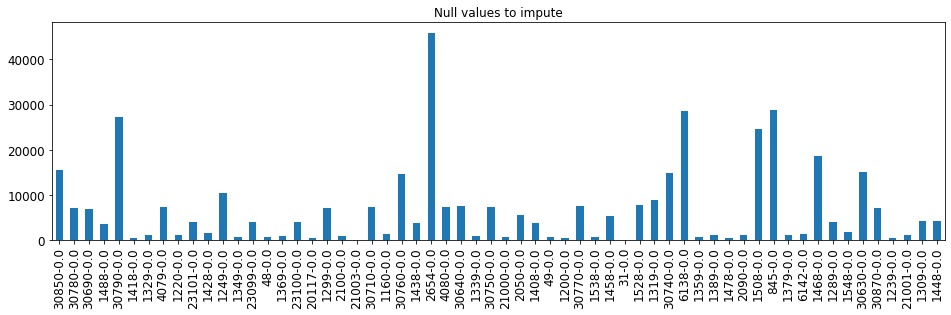

In [14]:
df2.loc[:,:'1448-0.0'].isnull().sum().plot(kind='bar', fontsize=12, figsize = (16,4))
plt.title('Null values to impute')

In [31]:
df2[numerical_cols+continuous_cols+categorical_cols][df2[numerical_cols+continuous_cols+categorical_cols].isna().any(axis=1)]

,1488-0.0,4079-0.0,1299-0.0,21003-0.0,1160-0.0,1438-0.0,4080-0.0,1458-0.0,1528-0.0,1319-0.0,845-0.0,1289-0.0,1309-0.0,30850-0.0,30780-0.0,30690-0.0,30790-0.0,23101-0.0,23099-0.0,48-0.0,23100-0.0,30710-0.0,30760-0.0,30640-0.0,30750-0.0,49-0.0,30770-0.0,30740-0.0,30630-0.0,30870-0.0,21001-0.0,1418-0.0,1329-0.0,1220-0.0,1428-0.0,1249-0.0,1349-0.0,1369-0.0,20117-0.0,2100-0.0,2654-0.0,1339-0.0,21000-0.0,2050-0.0,1408-0.0,1200-0.0,1538-0.0,31-0.0,6138-0.0,1359-0.0,1389-0.0,1478-0.0,2090-0.0,1508-0.0,1379-0.0,6142-0.0,1468-0.0,1548-0.0,1239-0.0,1448-0.0
0,0.763195,-0.494556,3.573839,-0.943676,-0.141043,-0.379582,-1.665243,NaN,-0.348540,-0.449967,NaN,1.560655,-0.168799,-1.276245,0.555076,0.861764,NaN,-0.949666,0.481766,-1.542473,-0.139329,-0.553579,0.950090,0.849077,NaN,-0.312934,0.985676,0.170598,0.411963,-0.843588,-0.786965,3.0,2.0,0.0,0.0,1.0,1.0,1.0,2.0,1.0,NaN,2.0,1001.0,2.0,1.0,3.0,2.0,0.0,1.0,2.0,1.0,1.0,1.0,3.0,1.0,1.0,NaN,2.0,0.0,3.0
1,-0.543069,0.770404,-0.085780,0.654717,1.460734,-0.156203,1.113646,0.830537,NaN,-0.449967,-0.170257,-0.431251,-0.755724,0.863908,0.160363,0.083395,-0.616193,1.556271,0.586976,1.767655,1.614456,0.146339,-0.484757,0.079792,0.323048,0.800714,-1.697037,-0.174707,-0.348082,0.429674,1.253579,2.0,2.0,0.0,1.0,1.0,4.0,2.0,2.0,0.0,NaN,2.0,1001.0,NaN,3.0,2.0,0.0,1.0,NaN,3.0,1.0,1.0,0.0,2.0,2.0,1.0,5.0,2.0,0.0,NaN
2,0.436629,0.137924,-0.085780,0.800026,-0.141043,-0.379582,1.709123,0.830537,-0.348540,1.105898,0.694895,0.066726,-0.755724,-0.567341,-0.353408,-0.307000,NaN,1.982451,-0.348225,1.048062,0.517115,-0.532193,-0.495526,-0.304851,-0.093118,1.205677,0.810351,-0.540003,-0.033580,1.121164,1.261736,2.0,3.0,0.0,3.0,NaN,2.0,2.0,2.0,0.0,7.0,2.0,1001.0,1.0,3.0,1.0,0.0,1.0,3.0,2.0,0.0,1.0,0.0,NaN,2.0,2.0,4.0,1.0,1.0,3.0
3,-1.196200,1.493238,-0.085780,-0.798367,-0.141043,-0.379582,-0.424668,0.830537,-0.348540,-0.449967,1.992623,0.066726,-0.755724,NaN,NaN,NaN,NaN,1.309087,-0.207945,1.191980,0.379948,NaN,NaN,NaN,5.317041,0.193270,NaN,NaN,NaN,NaN,0.419910,2.0,1.0,0.0,0.0,1.0,2.0,1.0,2.0,0.0,NaN,2.0,1001.0,1.0,2.0,2.0,1.0,1.0,3.0,3.0,2.0,1.0,0.0,2.0,2.0,1.0,4.0,2.0,0.0,3.0
4,-1.196200,-1.036681,1.286577,-1.670218,0.659846,0.067175,-1.367505,0.101630,0.099946,0.068655,0.694895,1.062678,-0.755724,-1.058487,-0.518587,0.126145,NaN,-1.375846,-0.196255,-2.046188,-0.923144,-0.450536,2.051127,-0.757608,-0.197160,-1.426581,1.900556,-0.311011,1.527695,-0.677631,-1.529086,2.0,2.0,0.0,0.0,4.0,1.0,2.0,2.0,0.0,NaN,2.0,1002.0,1.0,2.0,1.0,2.0,0.0,6.0,2.0,2.0,1.0,0.0,2.0,2.0,1.0,3.0,2.0,0.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101724,-1.196200,-0.042785,0.371672,1.090643,-0.141043,-0.602960,0.369301,0.101630,1.445401,0.068655,-0.602833,1.560655,-0.168799,NaN,0.541132,0.630270,2.409700,-0.804765,0.505146,-0.103287,-0.021757,0.124952,-0.928941,1.229713,-1.572820,0.395751,-0.786273,-0.446104,-0.232016,2.996484,0.126426,2.0,0.0,1.0,3.0,2.0,3.0,2.0,2.0,0.0,8.0,3.0,1001.0,1.0,1.0,2.0,0.0,0.0,NaN,1.0,1.0,1.0,0.0,1.0,2.0,2.0,4.0,3.0,0.0,3.0
101725,-1.196200,0.680049,-0.543233,-0.362442,-1.742821,1.407443,-0.722406,-1.356183,-1.245510,-0.449967,-0.602833,0.564702,-0.168799,0.174568,-0.969074,-1.107954,NaN,0.848813,0.633736,1.335899,1.202953,-0.184178,-0.716271,-0.905856,-0.694247,0.496992,0.301531,-0.935589,-1.104383,-0.811319,1.098137,1.0,1.0,0.0,3.0,3.0,3.0,1.0,2.0,0.0,4.0,3.0,1001.0,1.0,2.0,2.0,0.0,1.0,NaN,2.0,1.0,2.0,0.0,2.0,1.0,1.0,4.0,1.0,0.0,2.0
101726,0.110063,-1.217390,0.371672,-0.507750,0.659846,-0.714649,-0.176552,0.830537,0.099946,-0.449967,-0.170257,-0.929227,-1.342649,-1.280158,0.462833,0.885962,NaN,-1.256515,0.657116,-0.966799,-0.188318,-0.518583,1.356585,-0.120543,-0.613326,0.092029,0.181960,-0.185611,2.467455,0.239745,-0.482625,2.0,3.0,0.0,3.0,4.0,1.0,1.0,2.0,0.0,6.0,2.0,1001.0,1.0,2.0,3.0,0.0,0.0,4.0,2.0,1.0,2.0,1.0,

### Convert to correct data types

In [15]:
df2[categorical_cols] = df2[categorical_cols].astype('category')

### normalization of continuous and numeric variables

In [22]:
predictors = df.loc[:,:'1448-0.0']
predictors.shape

(101729, 60)

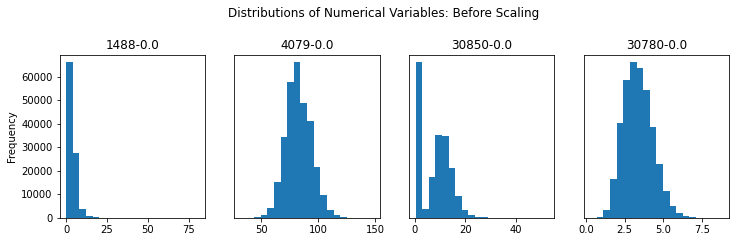

In [17]:
test_features = ['1488-0.0', '4079-0.0', '30850-0.0', '30780-0.0']

fig, ((ax1, ax2, ax3, ax4)) = plt.subplots(nrows=1, ncols=4, figsize = (12,3))
plt.suptitle('Distributions of Numerical Variables: Before Scaling', fontsize=12, y=1.1)

predictors[test_features[0]].plot(ax=ax1, kind='hist', bins=20, color='tab:blue').set_title(test_features[0])
predictors[test_features[1]].plot(ax=ax2, kind='hist', bins=20, color='tab:blue').set_title(test_features[1])
predictors[test_features[2]].plot(ax=ax3, kind='hist', bins=20,color='tab:blue').set_title(test_features[2])
predictors[test_features[3]].plot(ax=ax4, kind='hist', bins=20,color='tab:blue').set_title(test_features[3])

ax2.get_yaxis().set_visible(False)
ax3.get_yaxis().set_visible(False)
ax4.get_yaxis().set_visible(False)

In [16]:
df2.rename(columns = {'outcome_hypertension':'hypertension'}, inplace=True)
df2['age'] = df2['21003-0.0']

,30850-0.0,30780-0.0,30690-0.0,1488-0.0,30790-0.0,1418-0.0,1329-0.0,4079-0.0,1220-0.0,23101-0.0,1428-0.0,1249-0.0,1349-0.0,23099-0.0,48-0.0,1369-0.0,23100-0.0,20117-0.0,1299-0.0,2100-0.0,21003-0.0,30710-0.0,1160-0.0,30760-0.0,1438-0.0,2654-0.0,4080-0.0,30640-0.0,1339-0.0,30750-0.0,21000-0.0,2050-0.0,1408-0.0,49-0.0,1200-0.0,30770-0.0,1538-0.0,1458-0.0,31-0.0,1528-0.0,1319-0.0,30740-0.0,6138-0.0,1359-0.0,1389-0.0,1478-0.0,2090-0.0,1508-0.0,845-0.0,1379-0.0,6142-0.0,1468-0.0,1289-0.0,1548-0.0,30630-0.0,30870-0.0,1239-0.0,21001-0.0,1309-0.0,1448-0.0,outcome_myocardial_infarction,outcome_cardiomyopathies,outcome_ischemic_heart_disease,outcome_heart_failure,hypertension,outcome_peripheral_vascular_disease,outcome_cardiac_arrest,outcome_cerebral_infarction,outcome_arrhythmia,age
0,0.508,3.888,6.477,6.0,NaN,3.0,2.0,77.0,0.0,45.2,0.0,1.0,1.0,35.6,74.0,1.0,25.0,2.0,10.0,1.0,54.0,0.34,7.0,1.706,10.0,NaN,110.0,1.211,2.0,NaN,1001.0,2.0,1.0,102.0,3.0,26.339,2.0,NaN,0.0,2.0,0.0,5.622,1.0,2.0,1.0,1.0,1.0,3.0,NaN,1.0,1.0,NaN,6.0,2.0,1.593,0.977,0.0,24.5790,2.0,3.0,0,0,0,0,0,0,0,0,1,54.0
1,13.088,3.520,5.512,2.0,15.40,2.0,2.0,91.0,0.0,74.6,1.0,1.0,4.0,36.5,120.0,2.0,42.9,2.0,2.0,0.0,65.0,3.94,9.0,1.173,12.0,NaN,166.0,1.019,2.0,40.9,1001.0,NaN,3.0,113.0,2.0,10.701,0.0,7.0,1.0,NaN,0.0,5.052,NaN,3.0,1.0,1.0,0.0,2.0,16.0,2.0,1.0,5.0,2.0,2.0,1.390,2.358,0.0,35.0861,1.0,NaN,1,0,1,0,1,0,0,0,0,65.0
2,4.675,3.041,5.028,5.0,NaN,2.0,3.0,84.0,0.0,79.6,3.0,NaN,2.0,28.5,110.0,2.0,31.7,2.0,2.0,0.0,66.0,0.45,7.0,1.169,10.0,7.0,178.0,0.923,2.0,37.3,1001.0,1.0,3.0,117.0,1.0,25.317,0.0,7.0,1.0,2.0,3.0,4.449,3.0,2.0,0.0,1.0,0.0,NaN,18.0,2.0,2.0,4.0,3.0,1.0,1.474,3.108,1.0,35.1281,1.0,3.0,0,0,0,0,0,0,0,0,0,66.0
3,NaN,NaN,NaN,0.0,NaN,2.0,1.0,99.0,0.0,71.7,0.0,1.0,2.0,29.7,112.0,1.0,30.3,2.0,2.0,0.0,55.0,NaN,7.0,NaN,10.0,NaN,135.0,NaN,2.0,84.1,1001.0,1.0,2.0,107.0,2.0,NaN,1.0,7.0,1.0,2.0,0.0,NaN,3.0,3.0,2.0,1.0,0.0,2.0,21.0,2.0,1.0,4.0,3.0,2.0,NaN,NaN,0.0,30.7934,1.0,3.0,0,0,1,0,1,0,1,1,1,55.0
4,1.788,2.887,5.565,0.0,NaN,2.0,2.0,71.0,0.0,40.2,0.0,4.0,1.0,29.8,67.0,2.0,17.0,2.0,5.0,0.0,49.0,0.87,8.0,2.115,14.0,NaN,116.0,0.810,2.0,36.4,1002.0,1.0,2.0,91.0,1.0,31.672,2.0,5.0,0.0,3.0,1.0,4.827,6.0,2.0,2.0,1.0,0.0,2.0,18.0,2.0,1.0,3.0,5.0,2.0,1.891,1.157,0.0,20.7577,1.0,3.0,0,0,0,0,0,0,0,0,1,49.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101724,NaN,3.875,6.190,0.0,169.20,2.0,0.0,82.0,1.0,46.9,3.0,2.0,3.0,35.8,94.0,2.0,26.2,2.0,3.0,0.0,68.0,3.83,7.0,1.008,8.0,8.0,151.0,1.306,3.0,24.5,1001.0,1.0,1.0,109.0,2.0,16.010,0.0,5.0,0.0,6.0,1.0,4.604,NaN,1.0,1.0,1.0,0.0,1.0,15.0,2.0,2.0,4.0,6.0,3.0,1.421,5.142,0.0,29.2822,2.0,3.0,0,0,0,0,1,0,0,1,1,68.0
101725,9.036,2.467,4.035,0.0,NaN,1.0,1.0,90.0,0.0,66.3,3.0,3.0,3.0,36.9,114.0,1.0,38.7,2.0,1.0,0.0,58.0,2.24,5.0,1.087,26.0,4.0,129.0,0.773,3.0,32.1,1001.0,1.0,2.0,110.0,2.0,22.351,0.0,1.0,1.0,0.0,0.0,3.796,NaN,2.0,1.0,2.0,0.0,2.0,15.0,1.0,1.0,4.0,4.0,1.0,1.188,1.012,0.0,34.2857,2.0,2.0,0,0,0,1,1,0,0,0,0,58.0
101726,0.485,3.802,6.507,4.0,NaN,2.0,3.0,69.0,0.0,41.6,3.0,4.0,1.0,37.1,82.0,1.0,24.5,2.0,3.0,0.0,57.0,0.52,8.0,1.857,7.0,6.0,140.0,0.969,2.0,32.8,1001.0,1.0,2.0,106.0,3.0,21.654,0.0,7.0,0.0,3.0,0.0,5.034,4.0,2.0,1.0,2.0,1.0,2.0,16.0,1.0,1.0,2.0,1.0,2.0,2.142,2.152,0.0,26.1461,0.0,3.0,0,0,1,0,0,0,0,0,0,57.0
101727,0.725,2.863,4.664,0.0,5.09,3.0,1.0,73.0,0.0,44.9,1.0,1.0,1.0,46.3,102.0,2.0,38.7,1.0,3.0,0.0,64.0,2.75,6.0,1.159,4.0,NaN,148.0,0.898,1.0,33.2,1001.0,1.0,1.0,110.0,3.0,23.647,2.0,7.0,0.0,3.0,0.0,5.673,3.0,3.0,2.0,2.0,1.0,1.0,16.0,2.0,2.0,1.0,4.0,3.0,1.365,2.134,0.0,31.4652,6.0,3.0,0,0,1,0,1,0,0,0,0,64.0


In [23]:
scaler  = preprocessing.StandardScaler()
scaler.fit(df2[continuous_cols+numerical_cols])

StandardScaler()

In [24]:
X_scaled = scaler.transform(df2[continuous_cols+numerical_cols])
df2[continuous_cols+numerical_cols] = X_scaled
data_2 = df2.copy()
df2.head()

,30850-0.0,30780-0.0,30690-0.0,1488-0.0,30790-0.0,1418-0.0,1329-0.0,4079-0.0,1220-0.0,23101-0.0,1428-0.0,1249-0.0,1349-0.0,23099-0.0,48-0.0,1369-0.0,23100-0.0,20117-0.0,1299-0.0,2100-0.0,21003-0.0,30710-0.0,1160-0.0,30760-0.0,1438-0.0,2654-0.0,4080-0.0,30640-0.0,1339-0.0,30750-0.0,21000-0.0,2050-0.0,1408-0.0,49-0.0,1200-0.0,30770-0.0,1538-0.0,1458-0.0,31-0.0,1528-0.0,1319-0.0,30740-0.0,6138-0.0,1359-0.0,1389-0.0,1478-0.0,2090-0.0,1508-0.0,845-0.0,1379-0.0,6142-0.0,1468-0.0,1289-0.0,1548-0.0,30630-0.0,30870-0.0,1239-0.0,21001-0.0,1309-0.0,1448-0.0,outcome_myocardial_infarction,outcome_cardiomyopathies,outcome_ischemic_heart_disease,outcome_heart_failure,outcome_hypertension,outcome_peripheral_vascular_disease,outcome_cardiac_arrest,outcome_cerebral_infarction,outcome_arrhythmia
0,-1.276245,0.555076,0.861764,0.763195,NaN,3.0,2.0,-0.494556,0.0,-0.949666,0.0,1.0,1.0,0.481766,-1.542473,1.0,-0.139329,2.0,3.573839,1.0,-0.943676,-0.553579,-0.141043,0.950090,-0.379582,NaN,-1.665243,0.849077,2.0,NaN,1001.0,2.0,1.0,-0.312934,3.0,0.985676,2.0,NaN,0.0,-0.348540,-0.449967,0.170598,1.0,2.0,1.0,1.0,1.0,3.0,NaN,1.0,1.0,NaN,1.560655,2.0,0.411963,-0.843588,0.0,-0.786965,-0.168799,3.0,0,0,0,0,0,0,0,0,1
1,0.863908,0.160363,0.083395,-0.543069,-0.616193,2.0,2.0,0.770404,0.0,1.556271,1.0,1.0,4.0,0.586976,1.767655,2.0,1.614456,2.0,-0.085780,0.0,0.654717,0.146339,1.460734,-0.484757,-0.156203,NaN,1.113646,0.079792,2.0,0.323048,1001.0,NaN,3.0,0.800714,2.0,-1.697037,0.0,0.830537,1.0,NaN,-0.449967,-0.174707,NaN,3.0,1.0,1.0,0.0,2.0,-0.170257,2.0,1.0,5.0,-0.431251,2.0,-0.348082,0.429674,0.0,1.253579,-0.755724,NaN,1,0,1,0,1,0,0,0,0
2,-0.567341,-0.353408,-0.307000,0.436629,NaN,2.0,3.0,0.137924,0.0,1.982451,3.0,NaN,2.0,-0.348225,1.048062,2.0,0.517115,2.0,-0.085780,0.0,0.800026,-0.532193,-0.141043,-0.495526,-0.379582,7.0,1.709123,-0.304851,2.0,-0.093118,1001.0,1.0,3.0,1.205677,1.0,0.810351,0.0,0.830537,1.0,-0.348540,1.105898,-0.540003,3.0,2.0,0.0,1.0,0.0,NaN,0.694895,2.0,2.0,4.0,0.066726,1.0,-0.033580,1.121164,1.0,1.261736,-0.755724,3.0,0,0,0,0,0,0,0,0,0
3,NaN,NaN,NaN,-1.196200,NaN,2.0,1.0,1.493238,0.0,1.309087,0.0,1.0,2.0,-0.207945,1.191980,1.0,0.379948,2.0,-0.085780,0.0,-0.798367,NaN,-0.141043,NaN,-0.379582,NaN,-0.424668,NaN,2.0,5.317041,1001.0,1.0,2.0,0.193270,2.0,NaN,1.0,0.830537,1.0,-0.348540,-0.449967,NaN,3.0,3.0,2.0,1.0,0.0,2.0,1.992623,2.0,1.0,4.0,0.066726,2.0,NaN,NaN,0.0,0.419910,-0.755724,3.0,0,0,1,0,1,0,1,1,1
4,-1.058487,-0.518587,0.126145,-1.196200,NaN,2.0,2.0,-1.036681,0.0,-1.375846,0.0,4.0,1.0,-0.196255,-2.046188,2.0,-0.923144,2.0,1.286577,0.0,-1.670218,-0.450536,0.659846,2.051127,0.067175,NaN,-1.367505,-0.757608,2.0,-0.197160,1002.0,1.0,2.0,-1.426581,1.0,1.900556,2.0,0.101630,0.0,0.099946,0.068655,-0.311011,6.0,2.0,2.0,1.0,0.0,2.0,0.694895,2.0,1.0,3.0,1.062678,2.0,1.527695,-0.677631,0.0,-1.529086,-0.755724,3.0,0,0,0,0,0,0,0,0,1


In [26]:
df2.shape

(101729, 69)

### implement MissForest imputation (random forest regressor/classifier)

In [19]:
cat_indices = [] 
for i in range(len(categorical_cols)):
    index = df2.columns.get_loc(categorical_cols[i])
    cat_indices.append(index)

In [20]:
imputer = MissForest()
X_train = imputer.fit_transform(df2.loc[:,:'1448-0.0'], cat_vars=cat_indices)

/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:400: 

Iteration: 0


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:400: 

Iteration: 1


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:400: 

Iteration: 2


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:400: 

Iteration: 3


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:400: 

Iteration: 4


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:400: 

Iteration: 5


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:400: 

Iteration: 6


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:400: 

Iteration: 7


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:400: 

Iteration: 8


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:400: 

Iteration: 9


In [24]:
df_X_trained = pd.DataFrame(X_train, columns=df2.columns.tolist()[:-9])

In [29]:
print(len(df2.loc[:,:'1448-0.0'].columns.tolist()))

60


In [25]:
df_X_trained

,30850-0.0,30780-0.0,30690-0.0,1488-0.0,30790-0.0,1418-0.0,1329-0.0,4079-0.0,1220-0.0,23101-0.0,1428-0.0,1249-0.0,1349-0.0,23099-0.0,48-0.0,1369-0.0,23100-0.0,20117-0.0,1299-0.0,2100-0.0,21003-0.0,30710-0.0,1160-0.0,30760-0.0,1438-0.0,2654-0.0,4080-0.0,30640-0.0,1339-0.0,30750-0.0,21000-0.0,2050-0.0,1408-0.0,49-0.0,1200-0.0,30770-0.0,1538-0.0,1458-0.0,31-0.0,1528-0.0,1319-0.0,30740-0.0,6138-0.0,1359-0.0,1389-0.0,1478-0.0,2090-0.0,1508-0.0,845-0.0,1379-0.0,6142-0.0,1468-0.0,1289-0.0,1548-0.0,30630-0.0,30870-0.0,1239-0.0,21001-0.0,1309-0.0,1448-0.0
0,-1.279446,0.552978,0.856104,0.772987,0.160138,3.0,2.0,-0.492958,0.0,-0.947164,0.0,1.0,1.0,0.483027,-1.545793,1.0,-0.138009,2.0,3.546199,1.0,-0.948313,-0.555101,-0.139039,0.933693,-0.377692,6.0,-1.665131,0.850258,2.0,-0.362231,1001.0,2.0,1.0,-0.312803,3.0,0.981135,2.0,-0.255880,0.0,-0.343536,-0.449755,0.177819,1.0,2.0,1.0,1.0,1.0,3.0,5.996074,1.0,1.0,3.0,1.565603,2.0,0.403095,-0.842728,0.0,-0.788176,-0.168110,3.0
1,0.868954,0.158768,0.079159,-0.539868,-0.613795,2.0,2.0,0.775257,0.0,1.556107,1.0,1.0,4.0,0.588425,1.771461,2.0,1.617787,2.0,-0.084622,0.0,0.652782,0.157478,1.470442,-0.491565,-0.154516,7.0,1.106447,0.080170,2.0,0.319113,1001.0,1.0,3.0,0.796999,2.0,-1.715852,0.0,0.827023,1.0,-0.117632,-0.449755,-0.173128,3.0,3.0,1.0,1.0,0.0,2.0,-0.172754,2.0,1.0,5.0,-0.425927,2.0,-0.356404,0.428763,0.0,1.257227,-0.753584,1.0
2,-0.567810,-0.354348,-0.310521,0.444774,-0.070011,2.0,3.0,0.141149,0.0,1.981834,3.0,4.0,2.0,-0.348442,1.050319,2.0,0.519189,2.0,-0.084622,0.0,0.798336,-0.533328,-0.139039,-0.502261,-0.377692,7.0,1.700356,-0.304873,2.0,-0.096834,1001.0,1.0,3.0,1.200563,1.0,0.804877,0.0,0.827023,1.0,-0.343536,1.096772,-0.544393,3.0,2.0,0.0,1.0,0.0,2.0,0.685816,2.0,2.0,4.0,0.071956,1.0,-0.042128,1.119290,1.0,1.265403,-0.753584,3.0
3,0.541023,0.331835,0.296342,-1.196296,-0.297654,2.0,1.0,1.499951,0.0,1.309186,0.0,1.0,2.0,-0.207912,1.194547,1.0,0.381864,2.0,-0.084622,0.0,-0.802759,-0.090479,-0.139039,0.007462,-0.377692,7.0,-0.427819,0.328844,2.0,5.310474,1001.0,1.0,2.0,0.191652,2.0,-0.231662,1.0,0.827023,1.0,-0.343536,-0.449755,5.453302,3.0,3.0,2.0,1.0,0.0,2.0,1.973672,2.0,1.0,4.0,0.071956,2.0,0.277348,0.334732,0.0,0.421573,-0.753584,3.0
4,-1.060849,-0.519316,0.121831,-1.196296,-0.146259,2.0,2.0,-1.036478,0.0,-1.372890,0.0,4.0,1.0,-0.196202,-2.050592,2.0,-0.922722,2.0,1.276936,0.0,-1.676084,-0.450193,0.665702,2.027372,0.068661,7.0,-1.368176,-0.758102,2.0,-0.200820,1002.0,1.0,2.0,-1.422604,1.0,1.900884,2.0,0.095332,0.0,0.108272,0.065754,-0.311660,6.0,2.0,2.0,1.0,0.0,2.0,0.685816,2.0,1.0,3.0,1.067720,2.0,1.518025,-0.677001,0.0,-1.532064,-0.753584,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30926,-0.300711,-1.692306,-1.773431,1.101201,-0.310562,2.0,3.0,-1.851759,0.0,1.700854,3.0,1.0,2.0,-0.114226,1.266661,1.0,0.695749,2.0,-0.992327,0.0,-0.511651,-0.460090,-0.139039,-1.387366,0.515013,6.0,0.017613,-1.520167,1.0,1.335872,1001.0,1.0,2.0,0.191652,3.0,0.326290,1.0,0.827023,1.0,-0.253174,0.065754,-0.176207,3.0,3.0,1.0,2.0,0.0,2.0,0.256531,1.0,1.0,3.0,0.569838,2.0,-1.445144,0.068768,0.0,0.740460,-0.168110,3.0
30927,0.944610,0.329092,0.347266,-0.211654,0.404848,2.0,2.0,-0.583545,0.0,0.926032,1.0,1.0,2.0,-2.093358,-0.824651,2.0,-1.550493,2.0,0.369231,0.0,0.798336,-0.367059,2.275183,0.297274,-0.600868,6.0,-0.427819,0.352910,2.0,-0.397240,1001.0,1.0,4.0,-0.817258,3.0,-0.579316,1.0,0.095332,1.0,0.108272,1.096772,-0.142344,3.0,2.0,2.0,1.0,0.0,3.0,0.256531,2.0,2.0,4.0,0.071956,2.0,0.474181,-0.042637,0.0,-1.025672,1.588314,3.0
30928,-0.436822,-0.057619,-0.095553,-0.868082,-0.830305,2.0,1.0,-0.311784,1.0,1.406422,3.0,1.0,3.0,-1.866870,0.689748,2.0,-1.265446,2.0,0.369231,0.0,0.798336,0.769109,-0.943779,-0.117094,0.515013,6.0,0.858984,-0.048178,2.0,0.573303,1001.0,2.0,1.0,-0.010130,3.0,0.127612,1.0,0.461178,1.0

In [30]:
# add imputed values as columns to the untouched dataset
df2.loc[:,:'1448-0.0'] = df_X_trained

In [34]:
df2.isna().sum()

30850-0.0                              0
30780-0.0                              0
30690-0.0                              0
1488-0.0                               0
30790-0.0                              0
                                      ..
outcome_hypertension                   1
outcome_peripheral_vascular_disease    1
outcome_cardiac_arrest                 1
outcome_cerebral_infarction            1
outcome_arrhythmia                     1
Length: 69, dtype: int64

In [32]:
df2.to_csv('imputed_ukb46359.csv')

In [2]:
df = pd.read_csv('imputed_ukb46359.csv')

In [3]:
df.size

2165170

In [39]:
df = df.iloc[:,1:]
df.head()

,30850-0.0,30780-0.0,30690-0.0,1488-0.0,30790-0.0,1418-0.0,1329-0.0,4079-0.0,1220-0.0,23101-0.0,1428-0.0,1249-0.0,1349-0.0,23099-0.0,48-0.0,1369-0.0,23100-0.0,20117-0.0,1299-0.0,2100-0.0,21003-0.0,30710-0.0,1160-0.0,30760-0.0,1438-0.0,2654-0.0,4080-0.0,30640-0.0,1339-0.0,30750-0.0,21000-0.0,2050-0.0,1408-0.0,49-0.0,1200-0.0,30770-0.0,1538-0.0,1458-0.0,31-0.0,1528-0.0,1319-0.0,30740-0.0,6138-0.0,1359-0.0,1389-0.0,1478-0.0,2090-0.0,1508-0.0,845-0.0,1379-0.0,6142-0.0,1468-0.0,1289-0.0,1548-0.0,30630-0.0,30870-0.0,1239-0.0,21001-0.0,1309-0.0,1448-0.0,outcome_myocardial_infarction,outcome_cardiomyopathies,outcome_ischemic_heart_disease,outcome_heart_failure,outcome_hypertension,outcome_peripheral_vascular_disease,outcome_cardiac_arrest,outcome_cerebral_infarction,outcome_arrhythmia
0,-1.279446,0.552978,0.856104,0.772987,0.160138,3.0,2.0,-0.492958,0.0,-0.947164,0.0,1.0,1.0,0.483027,-1.545793,1.0,-0.138009,2.0,3.546199,1.0,-0.948313,-0.555101,-0.139039,0.933693,-0.377692,6.0,-1.665131,0.850258,2.0,-0.362231,1001.0,2.0,1.0,-0.312803,3.0,0.981135,2.0,-0.255880,0.0,-0.343536,-0.449755,0.177819,1.0,2.0,1.0,1.0,1.0,3.0,5.996074,1.0,1.0,3.0,1.565603,2.0,0.403095,-0.842728,0.0,-0.788176,-0.168110,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.868954,0.158768,0.079159,-0.539868,-0.613795,2.0,2.0,0.775257,0.0,1.556107,1.0,1.0,4.0,0.588425,1.771461,2.0,1.617787,2.0,-0.084622,0.0,0.652782,0.157478,1.470442,-0.491565,-0.154516,7.0,1.106447,0.080170,2.0,0.319113,1001.0,1.0,3.0,0.796999,2.0,-1.715852,0.0,0.827023,1.0,-0.117632,-0.449755,-0.173128,3.0,3.0,1.0,1.0,0.0,2.0,-0.172754,2.0,1.0,5.0,-0.425927,2.0,-0.356404,0.428763,0.0,1.257227,-0.753584,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
2,-0.567810,-0.354348,-0.310521,0.444774,-0.070011,2.0,3.0,0.141149,0.0,1.981834,3.0,4.0,2.0,-0.348442,1.050319,2.0,0.519189,2.0,-0.084622,0.0,0.798336,-0.533328,-0.139039,-0.502261,-0.377692,7.0,1.700356,-0.304873,2.0,-0.096834,1001.0,1.0,3.0,1.200563,1.0,0.804877,0.0,0.827023,1.0,-0.343536,1.096772,-0.544393,3.0,2.0,0.0,1.0,0.0,2.0,0.685816,2.0,2.0,4.0,0.071956,1.0,-0.042128,1.119290,1.0,1.265403,-0.753584,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.541023,0.331835,0.296342,-1.196296,-0.297654,2.0,1.0,1.499951,0.0,1.309186,0.0,1.0,2.0,-0.207912,1.194547,1.0,0.381864,2.0,-0.084622,0.0,-0.802759,-0.090479,-0.139039,0.007462,-0.377692,7.0,-0.427819,0.328844,2.0,5.310474,1001.0,1.0,2.0,0.191652,2.0,-0.231662,1.0,0.827023,1.0,-0.343536,-0.449755,5.453302,3.0,3.0,2.0,1.0,0.0,2.0,1.973672,2.0,1.0,4.0,0.071956,2.0,0.277348,0.334732,0.0,0.421573,-0.753584,3.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0
4,-1.060849,-0.519316,0.121831,-1.196296,-0.146259,2.0,2.0,-1.036478,0.0,-1.372890,0.0,4.0,1.0,-0.196202,-2.050592,2.0,-0.922722,2.0,1.276936,0.0,-1.676084,-0.450193,0.665702,2.027372,0.068661,7.0,-1.368176,-0.758102,2.0,-0.200820,1002.0,1.0,2.0,-1.422604,1.0,1.900884,2.0,0.095332,0.0,0.108272,0.065754,-0.311660,6.0,2.0,2.0,1.0,0.0,2.0,0.685816,2.0,1.0,3.0,1.067720,2.0,1.518025,-0.677001,0.0,-1.532064,-0.753584,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


### oversampling using ADASYN method

In [41]:
from imblearn.over_sampling import ADASYN